In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import math
import plotly.express as px
import pandas as pd
import numpy as np

## 1. Load the Karate Graph from NetworkX

In [2]:
def get_graph_info(graph):
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of edges:", graph.number_of_edges())
    print("Available nodes:", list(graph.nodes))
    print("Available edges:", list(graph.edges))
    if type(graph) == nx.classes.digraph.DiGraph:
        print("Connected components:", 
              list(nx.weakly_connected_components(directed_graph)))
    else:
        print("Connected components:", list(nx.connected_components(graph)))
    print("Node degree:", dict(graph.degree()))

In [3]:
# built-in graph from networkx
karate_graph = nx.karate_club_graph()
get_graph_info(karate_graph)

Number of nodes: 34
Number of edges: 78
Available nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Available edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)]
Connected components: [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,

In [4]:
# club color reference
nation_color_dict = {
    'Mr. Hi': '#aff8df',
    'Officer': '#ffcbc1'
}

# function to assign color for node visualization
def create_node_colors_from_graph(graph, club_color_dict):
    node_colors = []
    for node, club in list(graph.nodes(data="club")):
        if club in club_color_dict:
            node_colors.append(club_color_dict[club])
    return node_colors

# get node colors for plotting
node_colors = create_node_colors_from_graph(karate_graph, nation_color_dict)

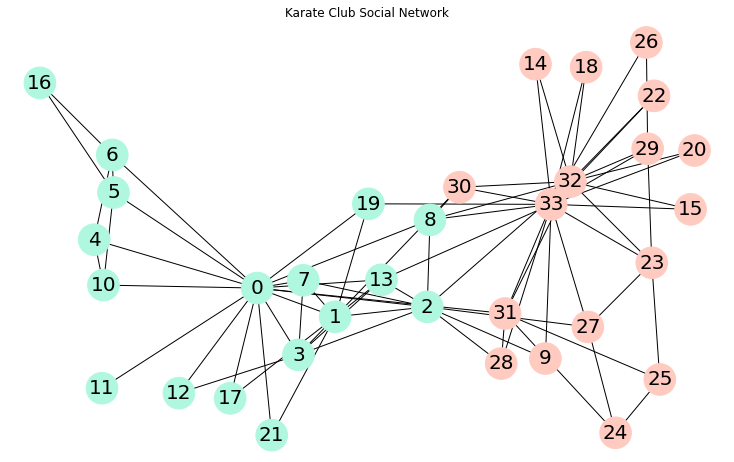

In [5]:
# create visualization
pos = nx.spring_layout(karate_graph, 
                       k=0.3, iterations=50,
                       seed=2)

plt.figure(1,figsize=(10,6)) 
nx.draw(karate_graph,
        pos = pos,
        node_color=node_colors,
        node_size=1000,
        with_labels=True,
        font_size = 20,
        font_color='black')
plt.title("Karate Club Social Network")
plt.show()

### Mint color nodes are from the "Mr. Hi" Karate club and the Salmon color nodes are from the "Officer" Karate club. 

## Description Statistics:

## 2. Link Prediction Measures
Given a network, predict which edges will be formed in the future

### 2.1 Number of Common Neighbors
1. Definition: 
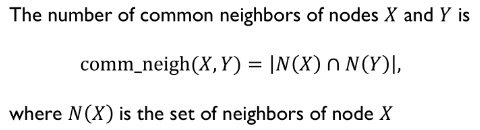

In [6]:
# get the common neighbor dataframe
def get_common_neighbors(graph):
    potential_egdes = nx.non_edges(graph)
    common_neighbors = []
    for source, target in potential_egdes:
        common_neighbors.append([source, target, 
            len(list(nx.common_neighbors(graph, source, target)))])
    common_neighbors = sorted(common_neighbors, key=lambda x: x[-1], reverse=True)
    return pd.DataFrame(common_neighbors, 
                        columns=["source", "target", "common_neighbors"])

In [7]:
# find the common neighbor measure for possible connections/edges
common_neighbors_df = get_common_neighbors(karate_graph)
common_neighbors_df["common_neighbors"].value_counts(normalize=True)

0    0.451346
1    0.327122
2    0.188406
3    0.026915
4    0.004141
6    0.002070
Name: common_neighbors, dtype: float64

In [8]:
common_neighbors_df["common_neighbors"].value_counts()

0    218
1    158
2     91
3     13
4      2
6      1
Name: common_neighbors, dtype: int64

### 45% of the possible edges have no common neighbors. The rest of the possible edges have at least 1 common neighbors. We can use these common neighbor values as features for link prediction.

In [9]:
common_neighbors_df.head()

,source,target,common_neighbors
0,2,33,6
1,0,33,4
2,7,13,4
3,0,32,3
4,1,8,3


In [10]:
list(nx.common_neighbors(karate_graph, 2, 33))

[8, 9, 13, 27, 28, 32]

### Although node 2 and node 33 are not connected, but they have the highest number (6) of common neighbors . Based on this measure, they are likely to be connected as friend in the Karate club social network.

In [11]:
# function to return a node's neighbor nodes as a list
def get_neighbors(graph, node):
    return [n for n in graph.neighbors(node)]

In [12]:
# function to return the subgraph containing 2 nodes' common neighbors
def get_common_neighbor_subgraph(graph, source, target):
    nodes = [source, target] + list(nx.common_neighbors(karate_graph, source, target))
    return graph.subgraph(nodes)

In [14]:
# function create node color list for likely connected two nodes with their
# common neighbors
def create_source_target_colors(graph, source, target):
    nodes = list(graph.nodes())
    potential_connected_node_colors = ["#EFD1BB"] * len(nodes)
    for index in range(len(nodes)):
        if nodes[index] in [source, target]:
            potential_connected_node_colors[index] = "#F47315"
    return potential_connected_node_colors

In [15]:
def visualize_likely_connected_nodes(graph, source, target):
    # get subgraph
    subgraph = get_common_neighbor_subgraph(karate_graph, source, target)

    # create visualization
    node_colors = create_source_target_colors(subgraph, source, target)
    title = f"Karate Club Social Network: Common Neighbors of Node {source} and {target}"
    pos = nx.spring_layout(subgraph, 
                           k=0.3, iterations=50,
                           seed=2)

    plt.figure(1,figsize=(10,6)) 
    nx.draw(subgraph,
            pos = pos,
            node_size=1000,
            node_color=node_colors,
            with_labels=True,
            font_size = 20,
            font_color='black')
    plt.title(title)
    plt.show() 

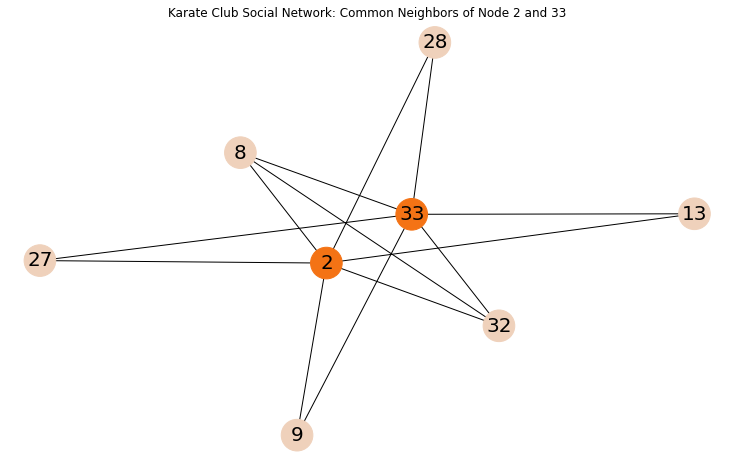

In [16]:
visualize_likely_connected_nodes(karate_graph, 2, 33)

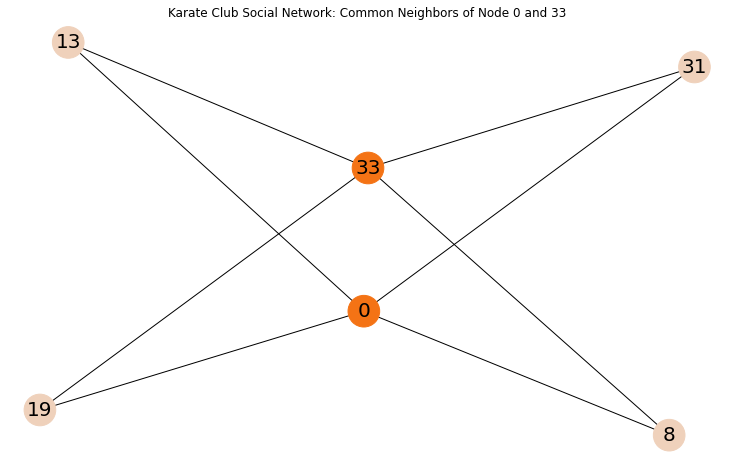

In [17]:
visualize_likely_connected_nodes(karate_graph, 0, 33)

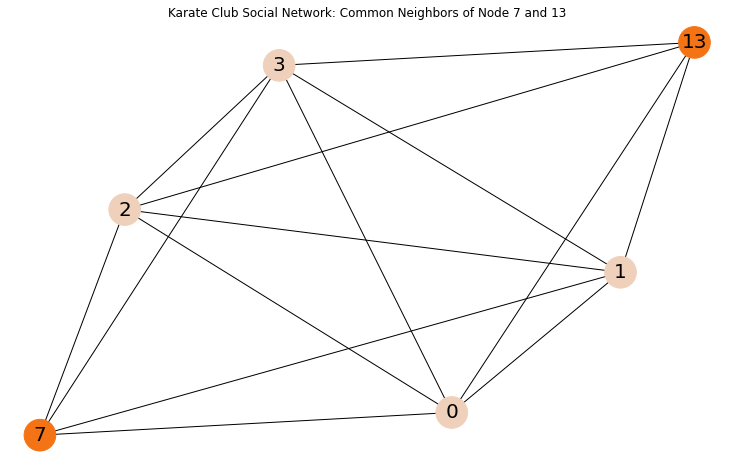

In [18]:
visualize_likely_connected_nodes(karate_graph, 7, 13)

### 2.2 Jaccard Coefficient

1. Definition:

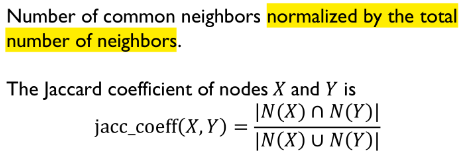

In [19]:
# function return the jaccard coefficient dataframe sorted by the
# jaccard coefficient value
def get_jaccard_coefficients(graph):
    return pd.DataFrame(sorted(list(nx.jaccard_coefficient(graph)),
                        key=lambda x: x[-1], reverse=True),
                        columns=["source", "target", "jaccard_coefficient"])

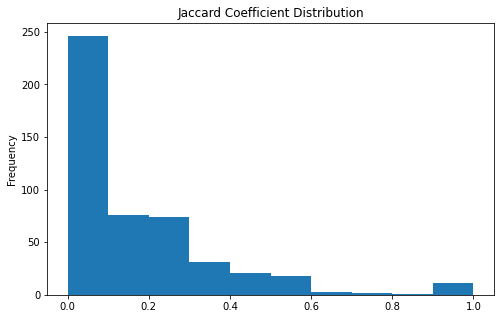

In [20]:
jaccard_coefficients_df = get_jaccard_coefficients(karate_graph)
jaccard_coefficients_df.jaccard_coefficient.plot.hist(bins=10, figsize=(8,5), 
                                                      title="Jaccard Coefficient Distribution");

### Overall, the Jaccard coefficient follows the same long tail distirbution like the common neighbor values' distribution. You can log transform the values before using it as feature for link prediction machine learning task. One observation of Jaccard coefficent is that potential connections between nodes with only few common neighbors will likely to have a higher coefficient value. If 2 nodes only have 1 neighbor by itself, their Jaccard coefficient will also be 1.

In [21]:
jaccard_coefficients_df.head()

,source,target,jaccard_coefficient
0,14,15,1.0
1,14,18,1.0
2,14,20,1.0
3,14,22,1.0
4,15,18,1.0


In [22]:
get_neighbors(karate_graph, 14)

[32, 33]

In [23]:
get_neighbors(karate_graph, 15)

[32, 33]

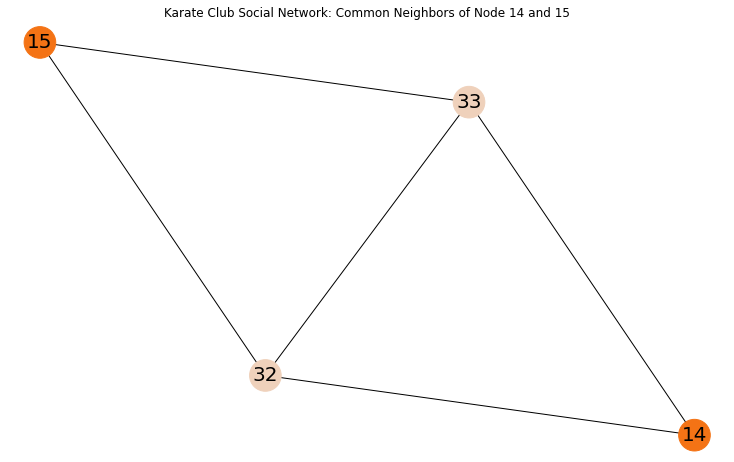

In [24]:
visualize_likely_connected_nodes(karate_graph, 14, 15)

### From the above examle of potential link between node 14 and 15, we can see they 2 common neighbors of node 32 and 33. Jaccard Coefficient will give the normalize comon neighbor measure instead of absolute measure like what is described in "section 2.1".

### 2.3: Resource Allocation Index
1. Definition:  
For each common neighbor u between X and Y:  
    I. Use 1 divide by the number of neighbor nodes of the common neighbor node u  
    II. Sum all the fractions calculated from the common neighbor nodes
    
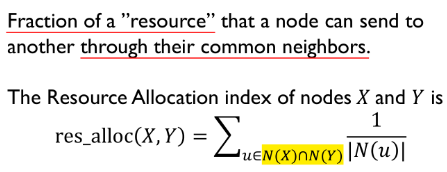

In [25]:
# function return the resource allocation index dataframe sorted by the
# resource allocation index value
def get_resource_allocation_index(graph):
    return pd.DataFrame(sorted(list(nx.resource_allocation_index(graph)),
                        key=lambda x: x[-1], reverse=True),
                        columns=["source", "target", "resource_allocation_index"])

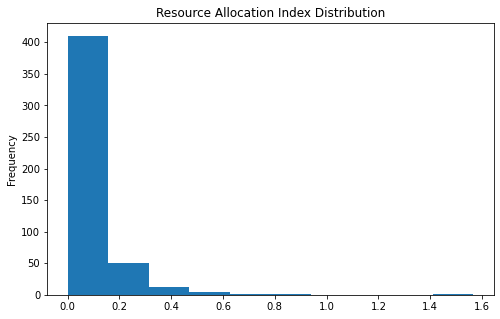

In [26]:
resource_allocation_index_df = get_resource_allocation_index(karate_graph)
resource_allocation_index_df.resource_allocation_index.plot.hist(bins=10, figsize=(8,5), 
    title="Resource Allocation Index Distribution");

In [27]:
resource_allocation_index_df.head()

,source,target,resource_allocation_index
0,2,33,1.566667
1,0,33,0.900000
2,1,33,0.783333
3,4,5,0.645833
4,6,10,0.645833


### Overall, the resource allocation index  follows the same long tail distirbution like the common neighbor values' distribution. You can log transform the values before using it as feature for link prediction machine learning task. One observation is that two potentially connected nodes with many connections will have resource allocation index greater than 1 when their neighbors have less common neighbors. In this way, the percentage of resources allocated will be higher per common neighbor nodes.

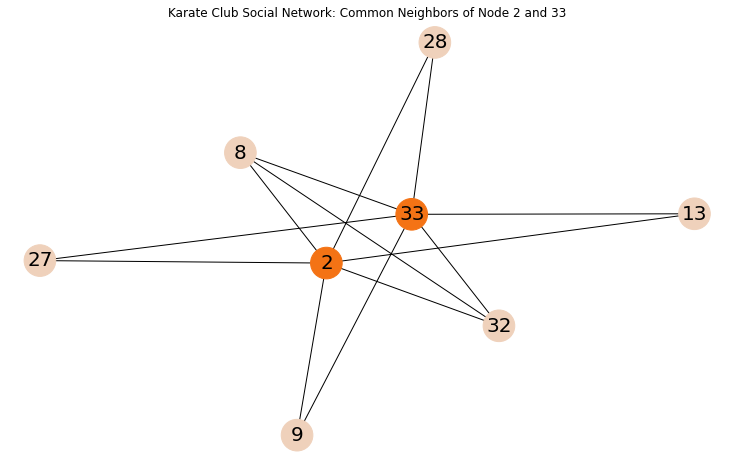

In [28]:
visualize_likely_connected_nodes(karate_graph, 2, 33)

In [29]:
common_neighbors = list(nx.common_neighbors(karate_graph, 2, 33))
common_neighbors

[8, 9, 13, 27, 28, 32]

In [30]:
# for each common neighor, let's study how many neighbor nodes they have
for node in common_neighbors:
    print(f"- Node {node} has {len(get_neighbors(karate_graph, node))} neighbor(s)")

- Node 8 has 5 neighbor(s)
- Node 9 has 2 neighbor(s)
- Node 13 has 5 neighbor(s)
- Node 27 has 4 neighbor(s)
- Node 28 has 3 neighbor(s)
- Node 32 has 12 neighbor(s)


In [31]:
1/5 + 1/2 + 1/5 + 1/4 + 1/3 + 1/12

1.5666666666666664

### For each common neighor of the two nodes 2 and 33, the above derivation is the why this potential link has resource allocation index of 1.566667.

### 2.4 Adamic-Adar Index

1. Definition:  
For each common neighbor u between X and Y:  
    I. Use 1 divide by the log number of neighbor nodes of the common neighbor node u  
    II. Sum all the fractions calculated from the common neighbor nodes
    
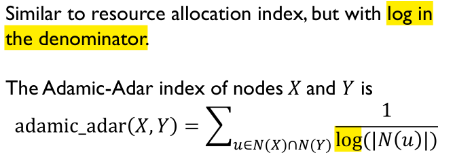

In [32]:
# function return the adamic adar index dataframe sorted by the
# resource allocation index value
def get_adamic_adar_index(graph):
    return pd.DataFrame(sorted(list(nx.adamic_adar_index(graph)),
                        key=lambda x: x[-1], reverse=True),
                        columns=["source", "target", "adamic_adar_index"])

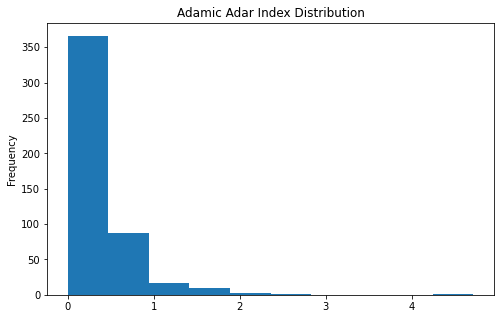

In [33]:
adamic_adar_index_df = get_adamic_adar_index(karate_graph)
adamic_adar_index_df.adamic_adar_index.plot.hist(bins=10, figsize=(8,5), 
    title="Adamic Adar Index Distribution");

In [34]:
adamic_adar_index_df.head()

,source,target,adamic_adar_index
0,2,33,4.719381
1,0,33,2.711020
2,1,33,2.252922
3,4,5,1.992261
4,6,10,1.992261


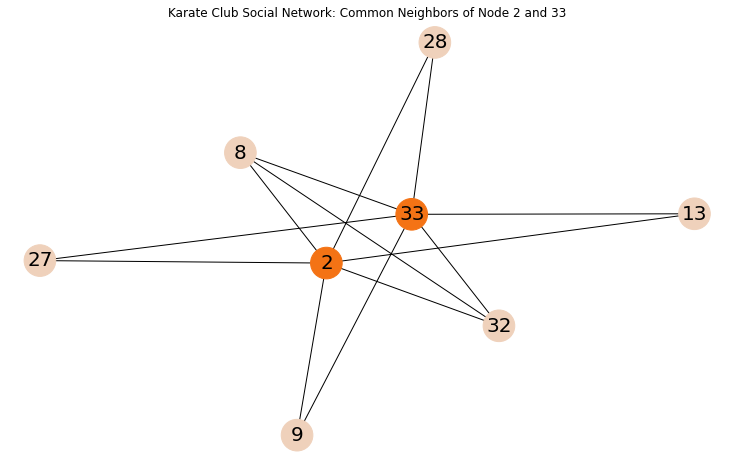

In [35]:
visualize_likely_connected_nodes(karate_graph, 2, 33)

### Adamic-Adar index will have similar pattern like the Resource Allocation Index except the values of the Adamic-Adar index will be higher due to the logorithm transform for the denominator of the common neighbor's connection count.

### 2.5 Preferential Attachment

1. Definition:  
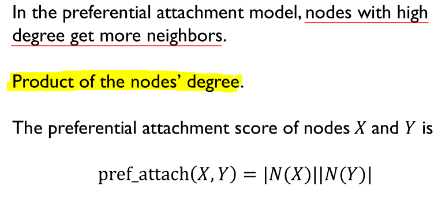